In [1]:
import os
import pickle
import torch
import numpy as np
from math import ceil
from model_vc import Generator
import librosa
import librosa.display
import matplotlib.pyplot as plt


metadata = pickle.load(open('/home/ytang363/7100_voiceConversion/autovc-master/metadata.pkl', "rb"))
train = pickle.load(open('/home/ytang363/7100_voiceConversion/VCTK-Corpus-0.92/spmel-test/train.pkl', "rb"))

# Test Speaker Embedding Model

In [2]:
import os
import pickle
from model_bl import D_VECTOR
from collections import OrderedDict
import numpy as np
import torch

speaker_encoder_model = '/home/ytang363/7100_voiceConversion/pretrain/3000000-BL.ckpt'
C = D_VECTOR(dim_input=80, dim_cell=768, dim_emb=256).eval().cuda()
c_checkpoint = torch.load(speaker_encoder_model)
new_state_dict = OrderedDict()
for key, val in c_checkpoint['model_b'].items():
    new_key = key[7:]
    new_state_dict[new_key] = val
C.load_state_dict(new_state_dict)

<All keys matched successfully>

In [15]:
num_uttrs = 10
len_crop = 128
rootDir = '/home/ytang363/7100_voiceConversion/VCTK-Corpus-0.92/spmel-16k'
dirName, subdirList, _ = next(os.walk(rootDir))
process_speakers = ['p225', 'p226', 'p227', 'p228', 'p229', 'p230', 'p231', 'p232', 'p233', 'p234', 'p236']
speakers = []

for speaker in sorted(subdirList):
    if speaker not in process_speakers:
        continue

    print('Processing speaker: %s' % speaker)
    utterances = []

    #### Add first element to utterances ####
    utterances.append(speaker) 
    _, _, fileList = next(os.walk(os.path.join(dirName,speaker)))
    
    #### speaker embedding ####
    assert len(fileList) >= num_uttrs # test to see if data set utterance is greater than the minimum
    idx_uttrs = np.random.choice(len(fileList), size=num_uttrs, replace=False) # randomly pick number of utterance for each speaker in VCTK
    embs = []
    for i in range(num_uttrs):
        tmp = np.load(os.path.join(dirName, speaker, fileList[idx_uttrs[i]]))
        candidates = np.delete(np.arange(len(fileList)), idx_uttrs) # remove the idx_uttrs and create a new array with size of [speaker uttr - len(idx_uttrs)]

        # choose another utterance if the current one is too short
        while tmp.shape[0] <= len_crop:
            idx_alt = np.random.choice(candidates)
            tmp = np.load(os.path.join(dirName, speaker, fileList[idx_alt]))
            candidates = np.delete(candidates, np.argwhere(candidates==idx_alt))

        left = np.random.randint(0, tmp.shape[0]-len_crop)
        melsp = torch.from_numpy(tmp[np.newaxis, left:left+len_crop, :]).cuda() # shape: [1, 128, 80]

        # D_VECTOR Model
        emb = C(melsp) # shape: (1, 256)
        embs.append(emb.detach().squeeze().cpu().numpy()) # shape: (10, 256), and after taking the mean, it becomes (256, )

    #### Add Second element to utterances ####
    utterances.append(np.mean(embs, axis=0)) # utterances = ['speaker', embs: (256, )]

    #### Add Third element to utterances ####
    idx_uttrs_spec = np.random.choice(len(fileList), size=1, replace=False)[0]
    spec = np.load(os.path.join(dirName, speaker, fileList[idx_uttrs_spec]))
    print(f'file name: {fileList[idx_uttrs_spec]}, shape: {spec.shape}')
    utterances.append(spec)

    speakers.append(utterances)

    
              

Processing speaker: p225


file name: p225_298_mic1.npy, shape: (194, 80)
Processing speaker: p226
file name: p226_076_mic1.npy, shape: (180, 80)
Processing speaker: p227
file name: p227_091_mic1.npy, shape: (190, 80)
Processing speaker: p228
file name: p228_157_mic1.npy, shape: (279, 80)
Processing speaker: p229
file name: p229_305_mic1.npy, shape: (146, 80)
Processing speaker: p230
file name: p230_017_mic1.npy, shape: (249, 80)
Processing speaker: p231
file name: p231_361_mic1.npy, shape: (137, 80)
Processing speaker: p232
file name: p232_328_mic1.npy, shape: (189, 80)
Processing speaker: p233
file name: p233_386_mic1.npy, shape: (136, 80)
Processing speaker: p234
file name: p234_245_mic1.npy, shape: (187, 80)
Processing speaker: p236
file name: p236_268_mic1.npy, shape: (195, 80)


In [23]:
path_dir = '/home/ytang363/7100_voiceConversion'
print(os.path.join(path_dir, 'metadata.pkl'))
with open(os.path.join(path_dir, 'metadata.pkl'), 'wb') as handle:
    pickle.dump(speakers, handle)

/home/ytang363/7100_voiceConversion/metadata.pkl


In [4]:
for sbmt_i in metadata:
    print(sbmt_i[0])
# print(metadata[0][0])
print(np.array(metadata[0][1]).shape)
print(np.array(metadata[1][2]).shape)

p225
p228
p256
p270
(256,)
(89, 80)


In [5]:
# Speaker embedding in the train.pkl
train[0][1].shape

(256,)

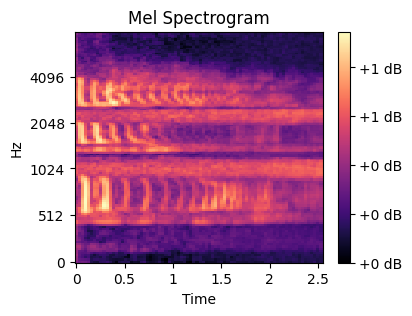

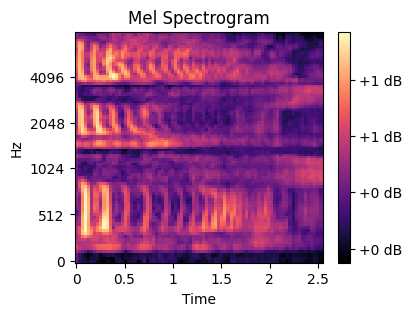

In [6]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

spec = np.load('/home/ytang363/7100_voiceConversion/VCTK-Corpus-0.92/spmel-16k/p225/p225_001_mic1.npy')

plt.figure(figsize=(4, 3))
librosa.display.specshow(spec, x_axis='time', y_axis='mel', sr=16000)
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')

plt.figure(figsize=(4, 3))
librosa.display.specshow(metadata[0][2], x_axis='time', y_axis='mel', sr=16000)
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [7]:
print(spec.shape)
print(metadata[0][2].shape)

(129, 80)
(90, 80)
